# Digital epidemiology
### University of Trento
### AA 2024/2025

Author: Michele Tizzoni

---
## Notebook 4
### Epidemics on networks

In this notebook, we'll use the Python library ["Epidemics on Networks" developed by Kiss, Miller & Simon](https://github.com/springer-math/Mathematics-of-Epidemics-on-Networks).

The library must be installed using pip:

    pip install EoN
  

The library documentation is [available here](http://epidemicsonnetworks.readthedocs.io/en/latest/). 

In [2]:
import EoN
import networkx as nx
import numpy as np
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
from operator import itemgetter


In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

# Simulate the spread of a SIR epidemic on the US airport network

In [5]:
airport_path = "./../datasets/USairport_2010.txt"
meta_path = "./../datasets/USairport_2010_codes.txt"

In [6]:
G = nx.Graph()
fh = open(airport_path, "r")
for line in fh.readlines():
    s = line.strip().split()
    G.add_edge(int(s[0]), int(s[1]))
fh.close()

In [7]:
G.code = {}
G.name = {}
G.pos = {}

lons = []
lats = []

finfo = open(meta_path, "r")
for line in finfo.readlines():
    s = line.strip().split()
    node = int(s[0])

    lon = float(s[4])
    lat = float(s[3])

    G.code[node] = s[1]
    G.name[node] = s[2]
    G.pos[node] = [lon, lat]

    lons.append(lon)
    lats.append(lat)
finfo.close()

## SIR model definition

In [8]:
# disease parameters
mu = 0.1  # infectious period
lambd = 0.01  # probability of infection given a contact

In [9]:
# we need to store the disease status of each node
G.disease_status = {}  # S=0, I=1, R=-1

infected_nodes = []  # list of infected nodes

In [10]:
# let's choose a seed
node_list = []

deg = dict(G.degree())
for i in sorted(deg.items(), key=itemgetter(1)):
    node_list.append(i[0])
seed = node_list[-1]

print("The seed is", G.name[seed])
print("The degree of the seed is", G.degree(seed))

The seed is Denver
The degree of the seed is 192


In [13]:
# initialize the network
infected_nodes.append(seed)

for n in G.nodes():
    if n in infected_nodes:
        G.disease_status[n] = 1
        # infected
    else:
        G.disease_status[n] = 0
        # susceptible

## SIR simulation

In [14]:
I_net = []

while len(infected_nodes) > 0:

    # transmission
    for i in infected_nodes:
        for j in G.neighbors(i):
            if G.disease_status[j] == 0:
                p = np.random.random()
                if p < lambd:
                    G.disease_status[j] = 1

    # recovery
    for k in infected_nodes:
        p = np.random.random()
        if p < mu:
            G.disease_status[k] = -1

    # update of disease status
    infected_nodes = []
    for n in G.nodes():
        if G.disease_status[n] == 1:
            infected_nodes.append(n)

    # store output
    I_net.append(len(infected_nodes))

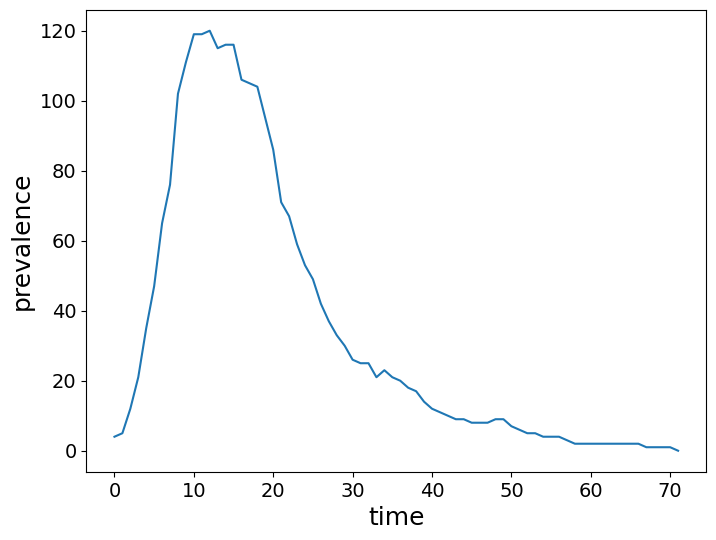

In [15]:
plt.figure(figsize=(8, 6))

plt.xlabel("time", fontsize=18)
plt.ylabel("prevalence", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.plot(range(0, len(I_net)), I_net)

In [16]:
recovered = 0
for n in G.nodes():
    if G.disease_status[n] == -1:
        recovered += 1

print("The total number of infected nodes is", recovered)
print("The final attack rate is", recovered / len(G.nodes()))

The total number of infected nodes is 249
The final attack rate is 0.6148148148148148


## Combine NetworkX and Geopandas to visualize the spreading

In [17]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [18]:
from pyproj import Transformer, transform

In [19]:
shape_path = "./../shapefiles/USA_shape.shp"

We import the USA shapefile

In [20]:
usa = gpd.read_file(shape_path)

<Axes: >

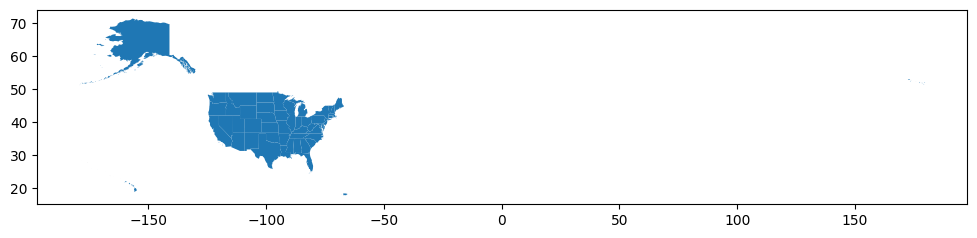

In [21]:
usa.plot(figsize=(12, 7))

In [22]:
usa.head()

AREA  PERIMETER  ST99_D00_  ST99_D00_I STATE    NAME LSAD REGION  \
0  271.25438  227.17142          2           1    02  Alaska   01      4   
1    0.00375    0.34984          3           2    02  Alaska   01      4   
2    0.00150    0.15353          4           3    02  Alaska   01      4   
3    0.03130    0.71223          5           4    02  Alaska   01      4   
4    0.88934    7.36032          6           5    02  Alaska   01      4   

  DIVISION  LSAD_TRANS                                           geometry  
0        9         NaN  POLYGON ((-147.78711 70.24536, -147.76510 70.2...  
1        9         NaN  POLYGON ((-166.05315 66.26494, -166.03187 66.2...  
2        9         NaN  POLYGON ((-168.89322 65.74470, -168.89875 65.7...  
3        9         NaN  POLYGON ((-168.21012 64.99896, -168.20791 65.0...  
4        9         NaN  POLYGON ((-171.73986 63.71712, -171.73321 63.7...

In [23]:
usa_cont = usa[
    (usa.NAME != "Alaska") & (usa.NAME != "Hawaii") & (usa.NAME != "Puerto Rico")
]

In [24]:
usa_cont.head()

AREA  PERIMETER  ST99_D00_  ST99_D00_I STATE        NAME LSAD REGION  \
81  25.53950   31.40718         83          82    27   Minnesota   01      2   
82  20.85358   30.71739         84          83    53  Washington   01      4   
83   0.00152    0.17436         85          84    53  Washington   01      4   
84  45.07846   34.97623         86          85    30     Montana   01      4   
85  24.45683   29.19034         87          86    16       Idaho   01      4   

   DIVISION  LSAD_TRANS                                           geometry  
81        4         NaN  POLYGON ((-95.15332 49.19311, -95.15342 49.249...  
82        9         NaN  POLYGON ((-122.29069 49.00243, -122.28565 49.0...  
83        9         NaN  POLYGON ((-123.09055 49.00198, -123.06793 49.0...  
84        8         NaN  POLYGON ((-116.04919 49.00091, -116.00103 49.0...  
85        8         NaN  POLYGON ((-116.04919 49.00091, -116.04918 48.8...

<Axes: >

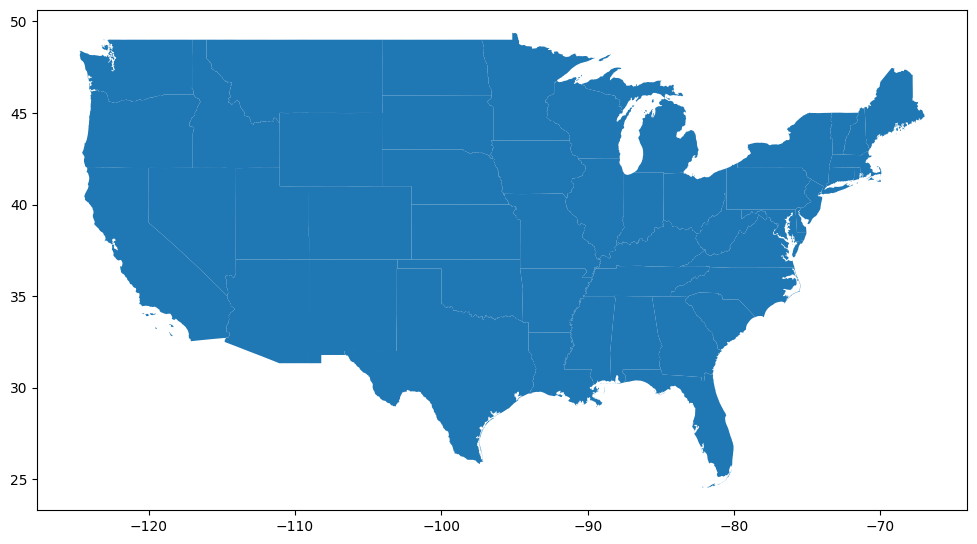

In [25]:
usa_cont.plot(figsize=(12, 7))

In [26]:
usa_cont.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
usa_cont_alb = usa_cont.to_crs('esri:102003')

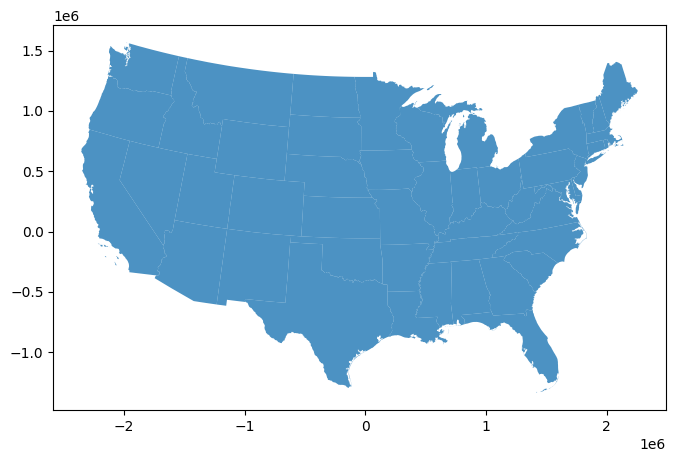

In [28]:
ax = usa_cont_alb.plot(figsize=(10, 5), alpha=0.8)

In [29]:
usa_cont_alb.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: USA_Contiguous_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Load metadata

In [30]:
df = pd.read_csv(meta_path, sep=" ", names=["id", "code", "name", "lat", "lon"])

In [31]:
df

id code              name        lat         lon
0      29  ABE         Allentown  40.654722  -75.438333
1      30  ABI           Abilene  32.409444  -99.679722
2      32  ABQ       Albuquerque  35.041667 -106.606389
3      33  ABR          Aberdeen  45.449722  -98.421667
4      35  ABY            Albany  31.532222  -84.196111
..    ...  ...               ...        ...         ...
410  1748  WYS  West_Yellowstone  44.686667 -111.104722
411  1752  XNA      Fayetteville  36.281944  -94.306944
412  1788  YKM            Yakima  46.566944 -120.537778
413  1795  YNG        Youngstown  41.256111  -80.669722
414  1821  YUM              Yuma  32.654167 -114.606944

[415 rows x 5 columns]

In [32]:
geo = [Point(xy) for xy in zip(df.lon, df.lat)]
#crs = {"init": "epsg:4326"}
crs=4326
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geo)

In [33]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

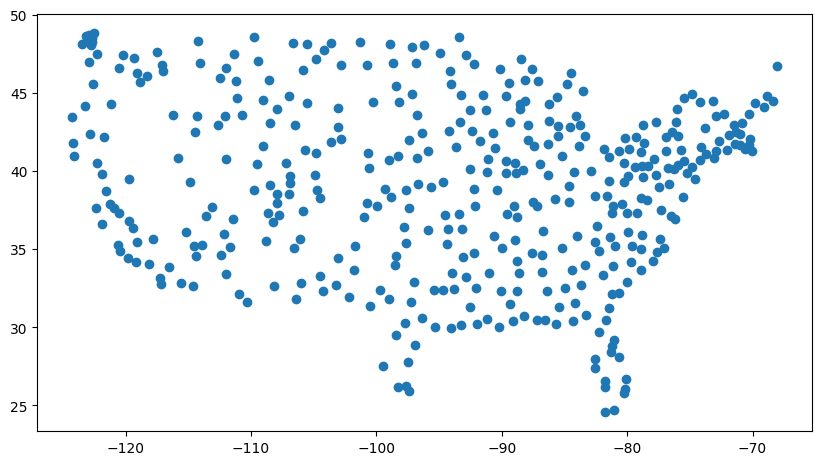

In [34]:
geo_df.plot(figsize=(10, 7))

In [35]:
original = 'epsg:4326'  # EPSG:4326 in your case
destination =   usa_cont_alb.crs # your new proj

In [36]:
transformer = Transformer.from_crs(original, destination)


In [37]:
G.pos_new = {}

for node in G:

    long, lat = G.pos[node]
    
    x, y = transformer.transform(lat, long)

    G.pos_new[node] = (x, y)

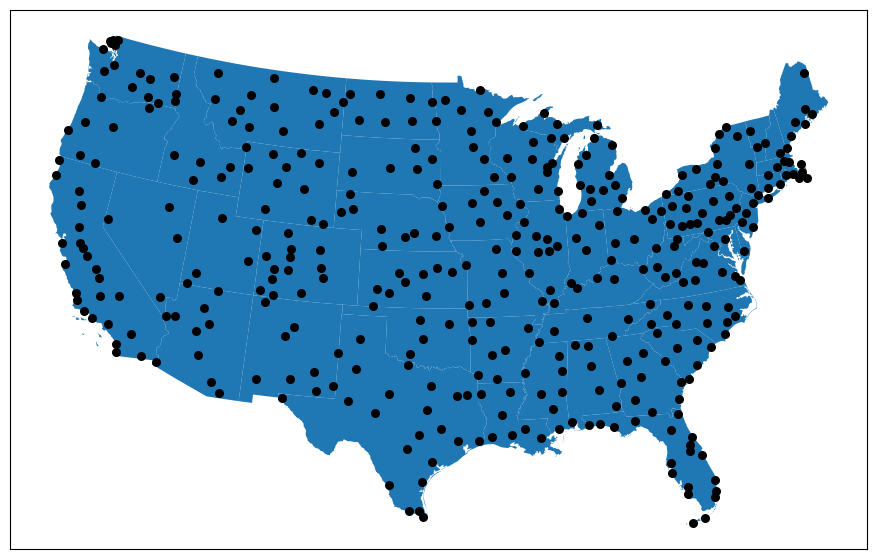

In [38]:
ax = usa_cont_alb.plot(figsize=(12, 7), alpha=1.)

nx.draw_networkx_nodes(
    G,
    pos=G.pos_new,
    node_size=30,
    node_color='black'
)

# SIR simulation

In [39]:
G.disease_status = {}  # S=0, I=1, R=-1

infected_nodes = []  # list of infected nodes

In [40]:
# initialize the network
infected_nodes.append(seed)

for n in G.nodes():
    if n in infected_nodes:
        G.disease_status[n] = 1
        # infected
    else:
        G.disease_status[n] = 0
        # susceptible

In [41]:
t = 0
node_color = [G.disease_status[v] for v in G]  # color code on disease status

<Figure size 1200x700 with 0 Axes>

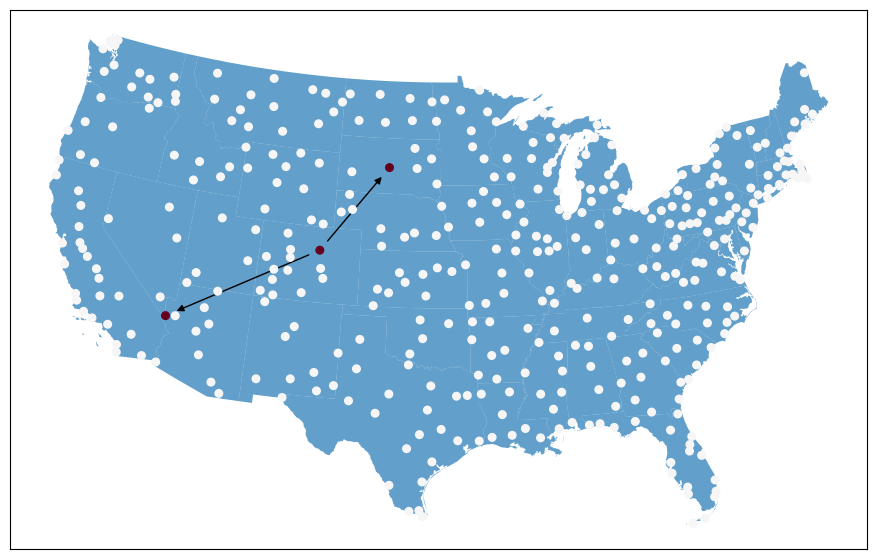

<Figure size 1200x700 with 0 Axes>

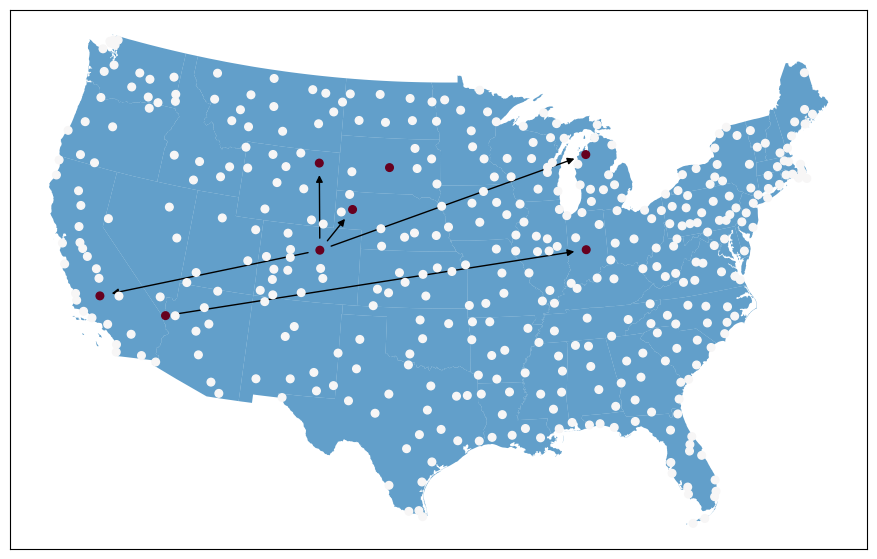

<Figure size 1200x700 with 0 Axes>

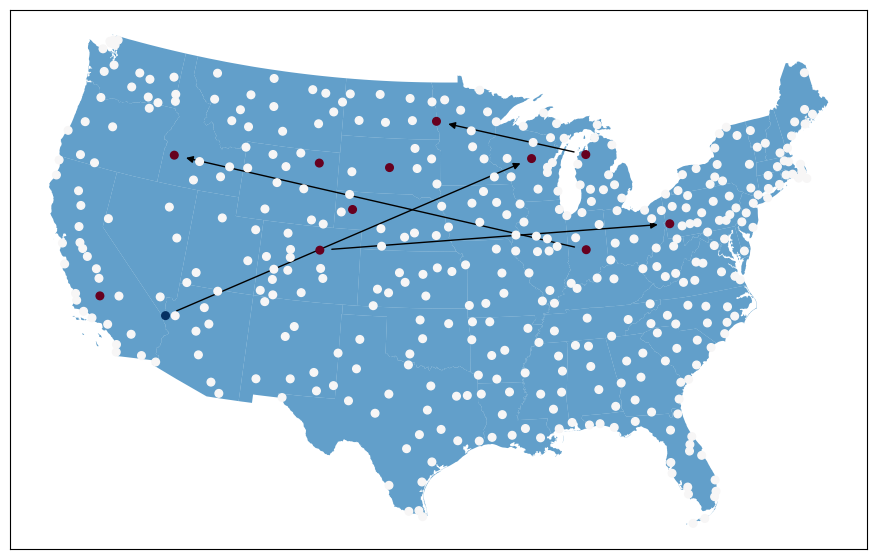

<Figure size 1200x700 with 0 Axes>

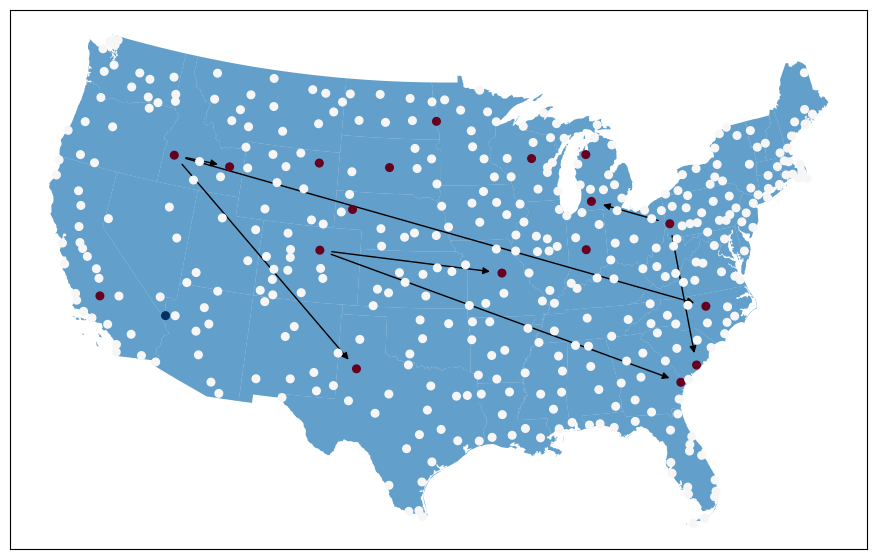

<Figure size 1200x700 with 0 Axes>

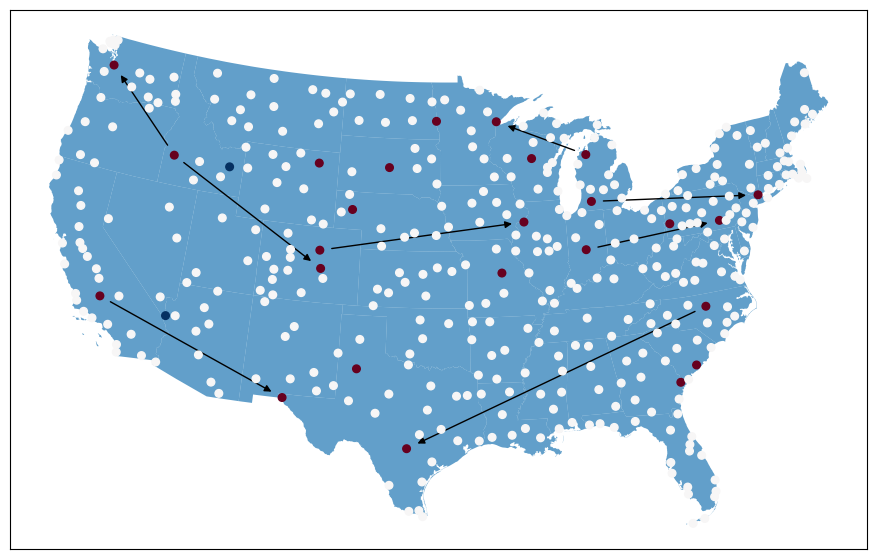

<Figure size 1200x700 with 0 Axes>

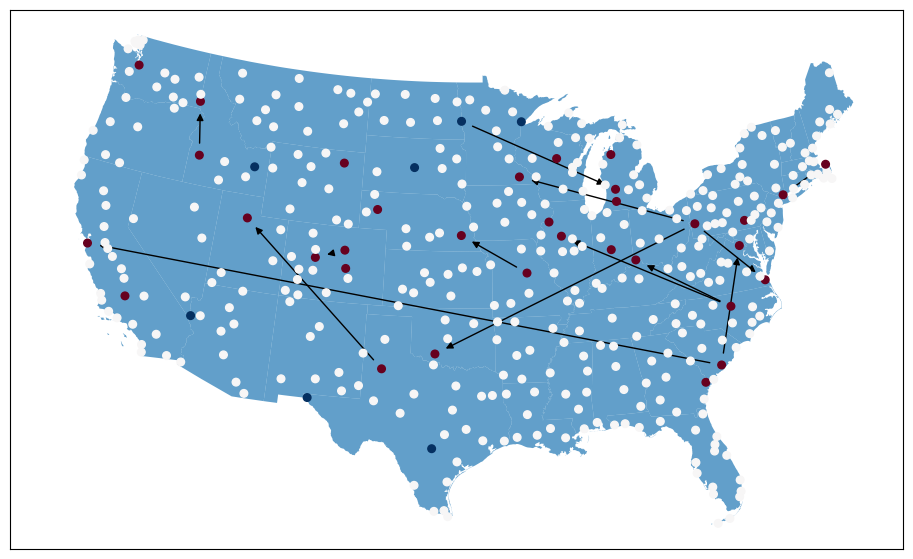

<Figure size 1200x700 with 0 Axes>

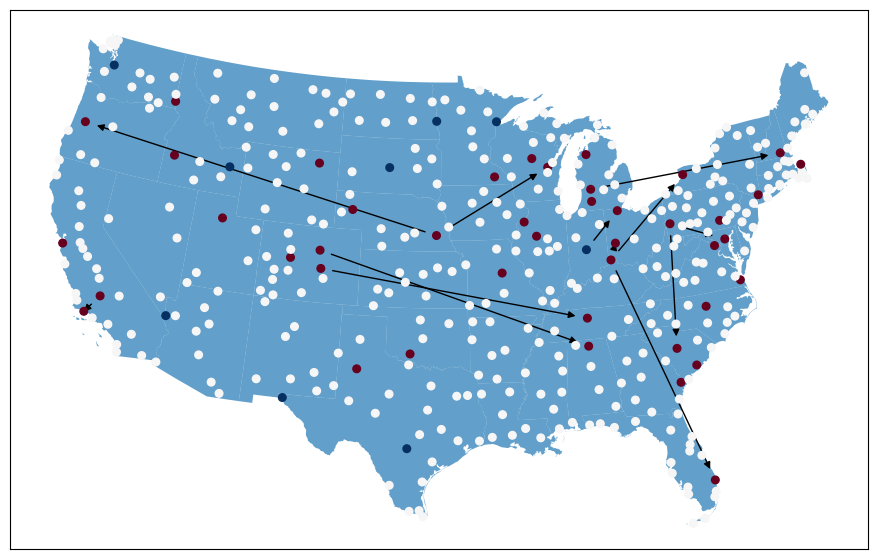

<Figure size 1200x700 with 0 Axes>

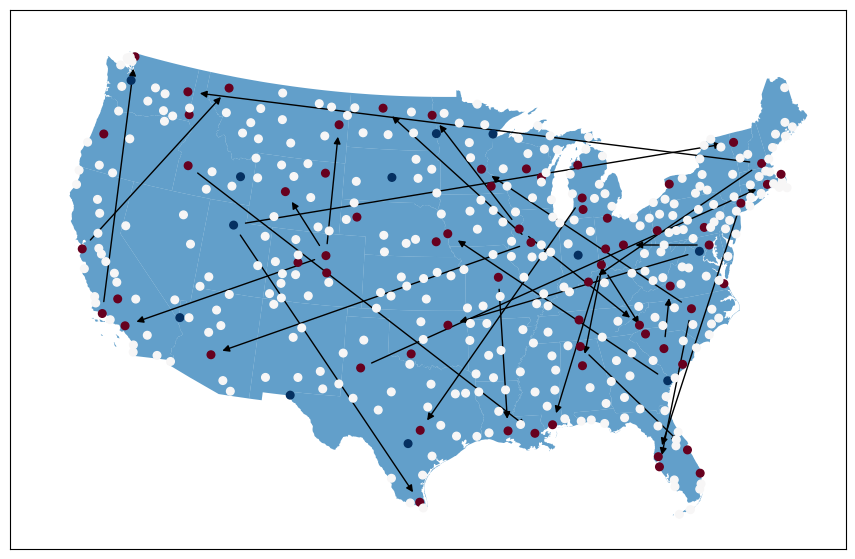

<Figure size 1200x700 with 0 Axes>

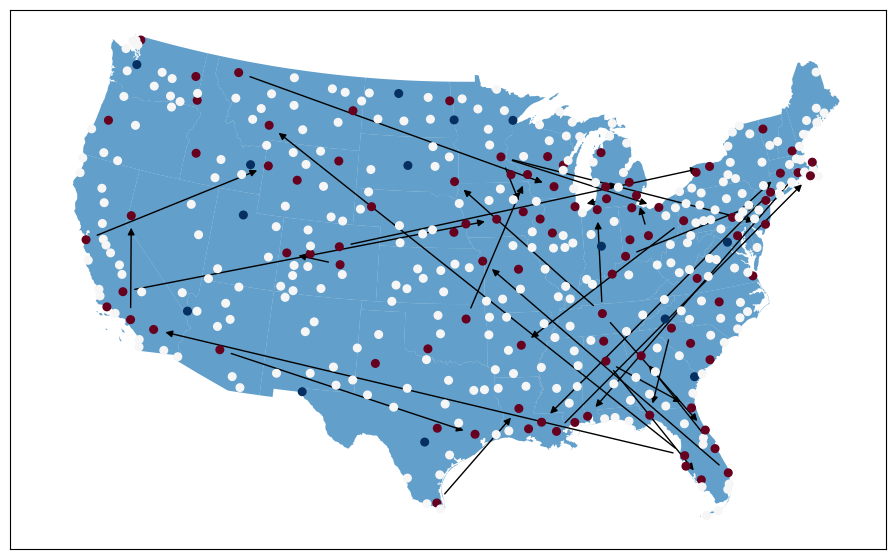

<Figure size 1200x700 with 0 Axes>

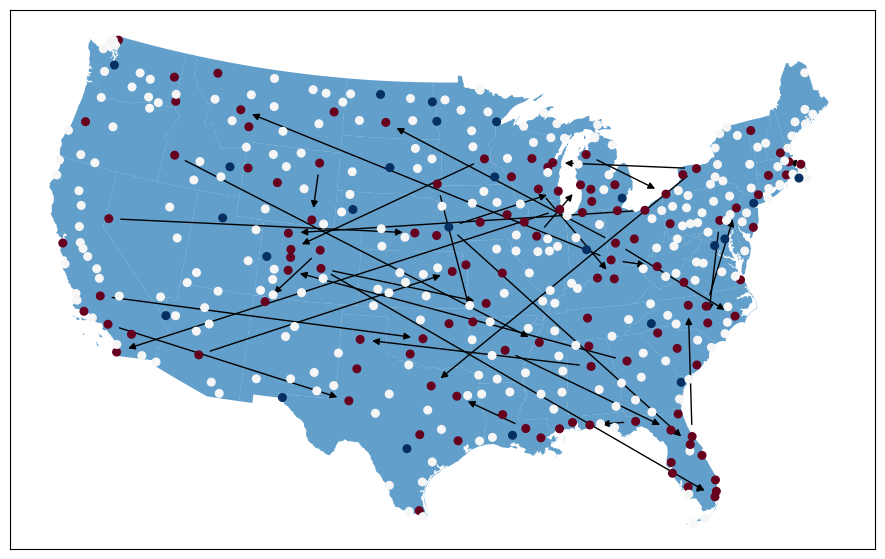

In [42]:
inf_G = nx.DiGraph()

while len(infected_nodes) > 0 and t < 10:
    
    for i in infected_nodes:
        for j in G.neighbors(i):
            if G.disease_status[j] == 0:
                p = np.random.random()
                if p < lambd:
                    G.disease_status[j] = 1
                    inf_G.add_edge(i,j)

    for k in infected_nodes:
        p = np.random.random()
        if p < mu:
            G.disease_status[k] = -1

    infected_nodes = []
    for n in G.nodes():
        if G.disease_status[n] == 1:
            infected_nodes.append(n)

    t += 1
    node_color = [G.disease_status[v] for v in G]  # color code on disease status

    plt.figure(figsize=(12, 7))
    
    ax = usa_cont_alb.plot(figsize=(12, 7), alpha=0.7)
    
    nx.draw_networkx_nodes(
        G,
        pos=G.pos_new,
        node_size=30,
        node_color=node_color,
        cmap=plt.cm.RdBu_r,
        vmin=-1,
        vmax=1,
    )
    
    nx.draw_networkx_edges(
        inf_G,
        pos=G.pos_new,
    )
    
    inf_G.clear_edges()



---
# Exploring the epidemic threshold for different network topologies

## Epidemic threshold for homogeneous networks

We simulate the spread of an SIR on an Erdős–Rényi graph with constant recovery rate, $\mu$, and fixed transmissibility, $\lambda$.

We first generate the ER network with NetworkX and store it in the variable `G`.

In [43]:
N=10000
p=0.002
G=nx.fast_gnp_random_graph(N, p)

In [44]:
nx.is_connected(G)

True

In [45]:
print(len(G))
print(len(G.edges))

10000
100186


---
#### For this network the epidemic threshold can be approximated as 

$\lambda_c = \frac{\mu}{\langle k \rangle}$

from the theory.

In [46]:
mu=0.2

Let's compute the critical value of $\lambda$ using the formula above. 

We expect that for values of $\lambda$<$\lambda_c$ the epidemic will not spread to the network.

In [47]:
avg_deg1=2*len(G.edges)/N
lc=mu/avg_deg1
print(lc)

0.009981434531770908


**As expected for this network, we have $\langle k^2 \rangle \sim \langle k \rangle^2 + \langle k \rangle$**

In [48]:
sum_k2=0
for i in G.nodes():
    
    k=G.degree(i)
    sum_k2+=k*k

avg_k2=sum_k2/N
print(avg_k2)

421.2474


In [49]:
avg_deg1**2 + avg_deg1

421.52658383999994

### Simulations of an SIR process
We simulate 20 realizations of a SIR model for increasing values of $\lambda$ using the [fast_SIR function of EoN](https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.fast_SIR.html?highlight=fast_SIR)

In [50]:
final_size=defaultdict(list)

for lambd in np.geomspace(0.0001, 1.0, 20):
    
    for r in range(0, 20):
        initial_size = 500
        
        t, S, I, R = EoN.fast_SIR(G, lambd, mu, initial_infecteds = range(initial_size))
        
        final_size[lambd].append(R[-1]/N)

In [51]:
homo_net_size=pd.DataFrame.from_dict(final_size)

In [52]:
homo_net_size

0.000100  0.000162  0.000264  0.000428  0.000695  0.001129  0.001833  \
0     0.0502    0.0508    0.0518    0.0513    0.0534    0.0565    0.0584   
1     0.0504    0.0507    0.0511    0.0517    0.0533    0.0562    0.0634   
2     0.0509    0.0506    0.0505    0.0525    0.0544    0.0562    0.0596   
3     0.0503    0.0507    0.0513    0.0519    0.0536    0.0554    0.0600   
4     0.0507    0.0515    0.0514    0.0518    0.0556    0.0555    0.0602   
5     0.0504    0.0505    0.0514    0.0520    0.0535    0.0560    0.0580   
6     0.0501    0.0508    0.0514    0.0511    0.0531    0.0575    0.0599   
7     0.0505    0.0505    0.0508    0.0524    0.0538    0.0573    0.0591   
8     0.0503    0.0506    0.0516    0.0521    0.0544    0.0559    0.0591   
9     0.0506    0.0505    0.0508    0.0518    0.0537    0.0540    0.0588   
10    0.0503    0.0507    0.0514    0.0524    0.0535    0.0549    0.0607   
11    0.0506    0.0511    0.0512    0.0516    0.0537    0.0548    0.0599   
12    0.0505    0.0506    0.0510    0.0520    0.0537    0.0560    0.0604   
13    0.0505    0.0507    0.0516    0.0520    0.0524    0.0561    0.0604   
14    0.0506    0.0510    0.0510    0.0519    0.0548    0.0563    0.0607   
15    0.0507    0.0507    0.0515    0.0530    0.0531    0.0558    0.0624   
16    0.0503    0.0506    0.0511    0.0526    0.0543    0.0566    0.0617   
17    0.0504    0.0503    0.0514    0.0521    0.0524    0.0580    0.0598   
18    0.0502    0.0513    0.0513    0.0515    0.0545    0.0557    0.0605   
19    0.0505    0.0506    0.0513    0.0517    0.0537    0.0560    0.0605   

    0.002976  0.004833  0.007848  0.012743  0.020691  0.033598  0.054556  \
0     0.0676    0.0915    0.1627    0.4655    0.7881    0.9386    0.9843   
1     0.0692    0.0886    0.1593    0.4474    0.7880    0.9398    0.9864   
2     0.0697    0.0871    0.1480    0.4532    0.7935    0.9359    0.9863   
3     0.0669    0.0866    0.1596    0.4690    0.7990    0.9298    0.9866   
4     0.0706    0.0880    0.1376    0.4317    0.7903    0.9342    0.9882   
5     0.0713    0.0923    0.1467    0.4380    0.7775    0.9300    0.9859   
6     0.0651    0.0881    0.1561    0.4385    0.7811    0.9354    0.9869   
7     0.0732    0.0893    0.1540    0.4276    0.7866    0.9356    0.9873   
8     0.0682    0.0952    0.1560    0.4578    0.7766    0.9400    0.9829   
9     0.0657    0.0824    0.1433    0.4415    0.7695    0.9301    0.9845   
10    0.0691    0.0857    0.1590    0.4197    0.7769    0.9400    0.9878   
11    0.0697    0.0852    0.1665    0.4475    0.7935    0.9355    0.9876   
12    0.0674    0.0827    0.1574    0.4358    0.7784    0.9349    0.9834   
13    0.0706    0.0823    0.1639    0.4145    0.7654    0.9321    0.9862   
14    0.0671    0.0859    0.1642    0.4551    0.7812    0.9380    0.9849   
15    0.0698    0.0935    0.1508    0.4124    0.7712    0.9369    0.9843   
16    0.0688    0.0937    0.1579    0.4491    0.7970    0.9373    0.9854   
17    0.0700    0.0879    0.1648    0.4443    0.7958    0.9398    0.9854   
18    0.0665    0.1004    0.1702    0.4024    0.7933    0.9325    0.9854   
19    0.0706    0.0882    0.1576    0.4928    0.7866    0.9373    0.9872   

    0.088587  0.143845  0.233572  0.379269  0.615848  1.000000  
0     0.9982    0.9998    0.9998       1.0       1.0       1.0  
1     0.9968    0.9995    1.0000       1.0       1.0       1.0  
2     0.9969    0.9999    1.0000       1.0       1.0       1.0  
3     0.9981    0.9997    0.9999       1.0       1.0       1.0  
4     0.9985    0.9998    1.0000       1.0       1.0       1.0  
5     0.9976    0.9992    1.0000       1.0       1.0       1.0  
6     0.9981    0.9997    1.0000       1.0       1.0       1.0  
7     0.9976    1.0000    1.0000       1.0       1.0       1.0  
8     0.9982    0.9995    1.0000       1.0       1.0       1.0  
9     0.9982    0.9999    0.9999       1.0       1.0       1.0  
10    0.9984    0.9999    1.0000       1.0       1.0       1.0  
11    0.9984    0.9997    1.00

Text(0.5, 0, '$\\lambda$')

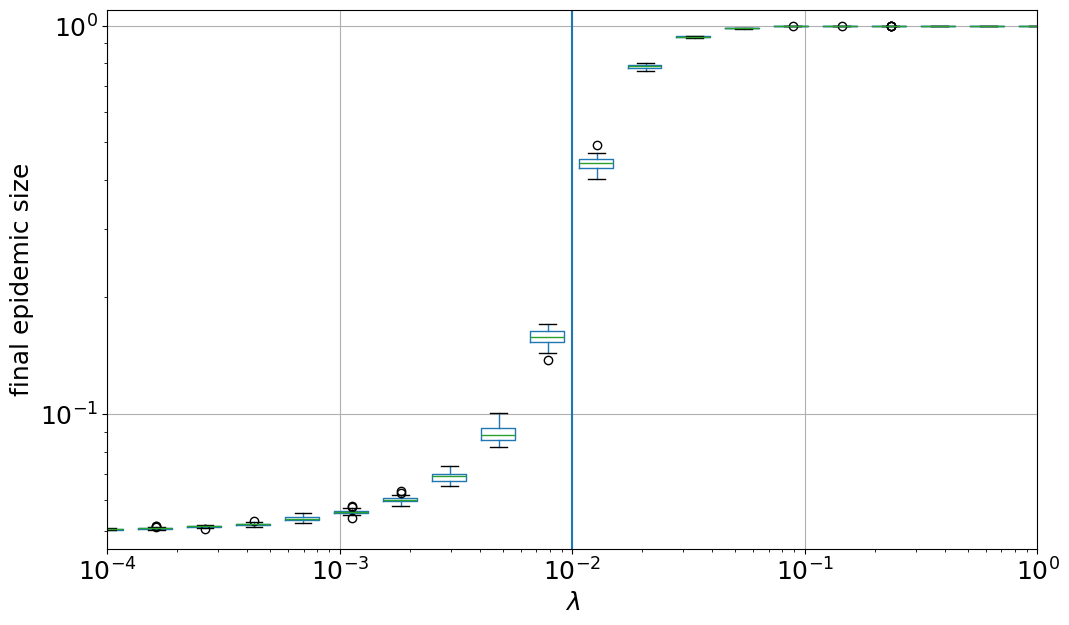

In [53]:
plt.figure(figsize=(12,7))

homo_net_size.boxplot(positions=np.array(homo_net_size.columns), 
                      widths=np.array(homo_net_size.columns)/3)

plt.vlines(x=lc, ymin=0.045, ymax=1.1)

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.0001, 1.0)
plt.ylim(0.045, 1.1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('final epidemic size', fontsize=18)
plt.xlabel('$\lambda$', fontsize=18)

## Epidemic threshold for Barabàsi-Albert model networks

In [54]:
N=10000
AB=nx.barabasi_albert_graph(N, 10)

In [55]:
nx.is_connected(AB)

True

In [56]:
print(len(AB.edges()))

99900


In [57]:
sum_k2=0
for i in AB.nodes():
    k=AB.degree(i)
    sum_k2+=k*k
avg_k2=sum_k2/N
print(avg_k2)    

949.7208


In [58]:
avg_deg=2*len(AB.edges)/N
print(avg_deg)

19.98


**The threshold can be approximated as $\lambda_c \sim \mu \frac{\langle k \rangle}{\langle k^2 \rangle - \langle k \rangle}$**

In [59]:
lambda_c=mu*avg_deg/(avg_k2-avg_deg)
print(lambda_c)

0.004297972079960351


In [60]:
lambda_c/lc

0.4305966308029076

### Simulations of an SIR process
We simulate 20 realizations of a SIR model for increasing values of $\lambda$

In [61]:
final_size_AB=defaultdict(list)

for lambd in np.geomspace(0.0001, 1.0, 20):
    for r in range(0, 20):
        initial_size = 500
        t, S, I, R = EoN.fast_SIR(AB, lambd, mu, initial_infecteds = range(initial_size))
        
        final_size_AB[lambd].append(R[-1]/N)

In [62]:
sf_net_size=pd.DataFrame.from_dict(final_size_AB)

In [63]:
sf_net_size.tail()

0.000100  0.000162  0.000264  0.000428  0.000695  0.001129  0.001833  \
15    0.0514    0.0526    0.0542    0.0574    0.0611    0.0700    0.0859   
16    0.0518    0.0522    0.0539    0.0585    0.0601    0.0716    0.0843   
17    0.0515    0.0535    0.0542    0.0587    0.0615    0.0706    0.0890   
18    0.0521    0.0534    0.0538    0.0572    0.0631    0.0670    0.0786   
19    0.0531    0.0521    0.0550    0.0553    0.0620    0.0754    0.0851   

    0.002976  0.004833  0.007848  0.012743  0.020691  0.033598  0.054556  \
15    0.1029    0.1543    0.2827    0.4797    0.6752    0.8673    0.9568   
16    0.1009    0.1655    0.2684    0.4670    0.6824    0.8687    0.9552   
17    0.1075    0.1799    0.2703    0.4669    0.6905    0.8688    0.9548   
18    0.1065    0.1687    0.2763    0.4717    0.6927    0.8692    0.9587   
19    0.1070    0.1585    0.2641    0.4554    0.6913    0.8625    0.9611   

    0.088587  0.143845  0.233572  0.379269  0.615848  1.000000  
15    0.9899    0.9985    0.9999       1.0       1.0       1.0  
16    0.9893    0.9991    0.9999       1.0       1.0       1.0  
17    0.9906    0.9992    0.9998       1.0       1.0       1.0  
18    0.9910    0.9981    0.9998       1.0       1.0       1.0  
19    0.9904    0.9990    0.9999       1.0       1.0       1.0

Text(0.5, 0, '$\\lambda$')

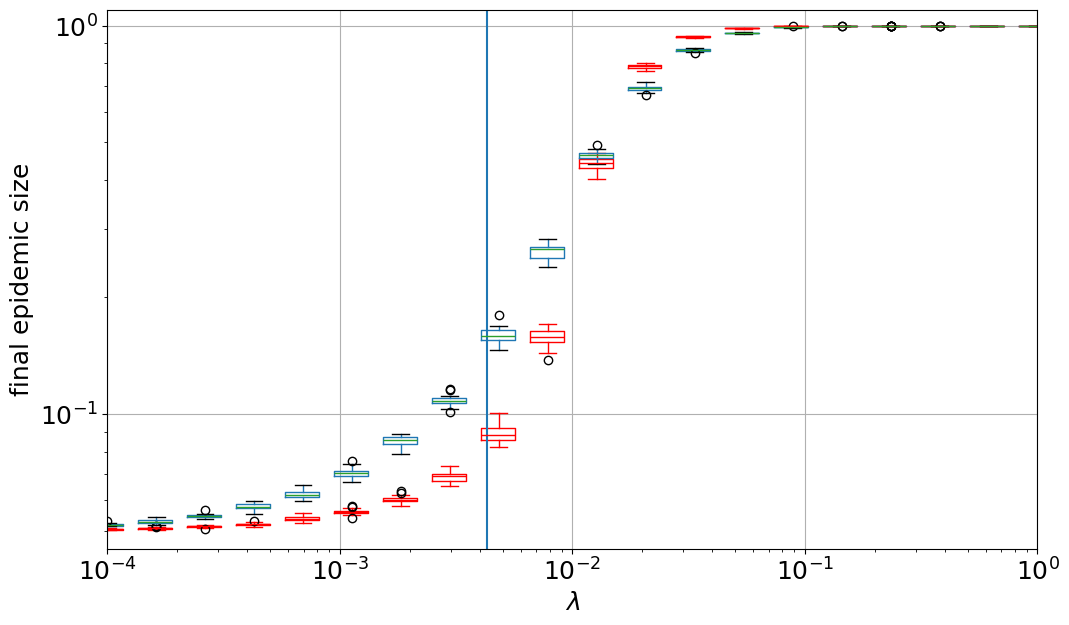

In [64]:
plt.figure(figsize=(12,7))

homo_net_size.boxplot(positions=np.array(homo_net_size.columns), widths=np.array(homo_net_size.columns)/3, color='r' )

plt.vlines(x=lambda_c, ymin=0.04, ymax=1.1)
sf_net_size.boxplot(positions=np.array(sf_net_size.columns), widths=np.array(sf_net_size.columns)/3)

plt.yscale('log')
plt.xscale('log')
plt.xlim(0.0001, 1.0)
plt.ylim(0.045, 1.1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('final epidemic size', fontsize=18)
plt.xlabel('$\lambda$', fontsize=18)